In [6]:
import jax
import jax.numpy as jnp
import numpy as np


In [3]:
import flax
from flax import linen as nn

#Used nn.Compact
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

In [5]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [10]:
rng = jax.random.PRNGKey(0)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))

params = model.init(init_rng, inp)
print(params)

{'params': {'Dense_0': {'kernel': Array([[-1.3251878 , -0.5832053 ,  1.0900751 , -0.75403666,  0.51737726,
         0.08046225, -0.3341975 ,  1.1461476 ],
       [-0.912002  , -0.8927214 , -0.3851325 ,  1.361964  ,  0.43919426,
         0.02007907, -0.3756649 ,  0.854208  ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'Dense_1': {'kernel': Array([[-0.10199455],
       [ 0.03335915],
       [ 0.3028594 ],
       [-0.03044848],
       [ 0.33398977],
       [ 0.5054317 ],
       [ 0.01182433],
       [ 0.11016198]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


In [13]:
import torch.utils.data as data

class XORDataset(data.Dataset):
    def __init__(self, size, seed, std=0.1):
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continous_xor()

    def generate_continous_xor(self):
        data = self.np_rng.randint(low=0, high=2, size=(self.size,2)).astype(np.float32)
        label = (data.sum(axis=1) == 1).astype(np.int32)

        #Add that gaussian noise
        data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

        self.data = data
        self.label = label
    
    def __len__(self):
        return self.size
    
    def __getitem__(self,idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label



In [14]:
dataset = XORDataset(size=200, seed=42)
print('Dataset Size', len(dataset))
print('Data Point 1:', dataset[1])


Dataset Size 200
Data Point 1: (array([ 0.02930725, -0.07143514], dtype=float32), 0)


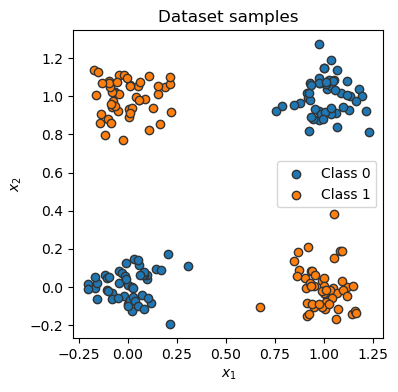

In [23]:
import matplotlib.pyplot as plt

def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
visualize_samples(dataset.data, dataset.label)
plt.show()



In [24]:
#Collate Function

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 0.9747432   0.87522167]
 [-0.02081222 -0.04930009]
 [-0.20251426  0.01864543]
 [ 1.1179297   1.0067519 ]
 [-0.16064464  0.02034636]
 [ 0.92408675  1.0150393 ]
 [ 0.97353435  1.2720169 ]
 [-0.17131345  1.1353872 ]]
Data labels (8,) 
 [0 0 0 0 0 0 0 1]


In [25]:
"""
Optimization Steps:

Get a batch from the data loader

Obtain the predictions from the model for the batch

Calculate the loss based on the difference between predictions and labels

Backpropagation: calculate the gradients for every parameter with respect to the loss

Update the parameters of the model in the direction of the gradient
"""

#Implementing SGD
%pip install optax

/Users/atreyasridharan/miniforge3/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [28]:
import optax
from flax.training import train_state

#Since we are not calculating gradients through tensor, but rather functions
#We do not have optimizer.step and optimizer.backward..
#Instead optimizer is a function on the parameters and gradients

#Have to create "TrainState" through flax.training to bundle parameters, optimizer and forward step
optimizer = optax.sgd(learning_rate=0.1)

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [ ]:
def calculate_loss_acc(state, params, batch):
    data_input,labels = batch
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0 ).astype(jnp.float32)

    loss = optax.sigmoid_binary_cross_entropy(logits,labels).mean()
    acc = (pred_labels == labels).mean()

    return loss, acc
 

In [31]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.9087383, dtype=float32), Array(0.25, dtype=float32))

In [34]:
@jax.jit

#input to each training step, we have training state and batch
#Want to calculate loss for the input and take grad of it
#Update parameters with our optimizer and return new data

def train_step(state, batch):
    #Gradient Function

    #Create a function that evaluates both function and the gradient of function
    grad_fn = jax.value_and_grad(calculate_loss_acc, argnums=1, has_aux=True)

    #Determine gradients
    (loss, acc), grads = grad_fn(state, state.params, batch)
    #Update Step
    state = state.apply_gradients(grads=grads)

    return state, loss, acc


In [35]:
@jax.jit  

def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [36]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [41]:
#Do not need to explictly push our model to GPU
# I am using Mac Silicion (For all my fans) as my GPU 
from tqdm import tqdm
def train_model(state, data_loader, num_epochs=100):
    for epoch in tqdm(range(num_epochs)):
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
    return state

In [42]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

100%|██████████| 100/100 [00:00<00:00, 104.83it/s]


In [44]:
#Skipping Storing checkpoints 
#Straight to EVAL
test_dataset = XORDataset(size=500, seed=123)
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)


def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted avg
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


In [45]:
#Important - Binding model parameters
#Instead of keeping track of model and params sept
#Bind params to a specific model (TRANSFER LEARNING)

trained_model = model.bind(trained_model_state.params)

data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter 
out.shape

(8, 1)

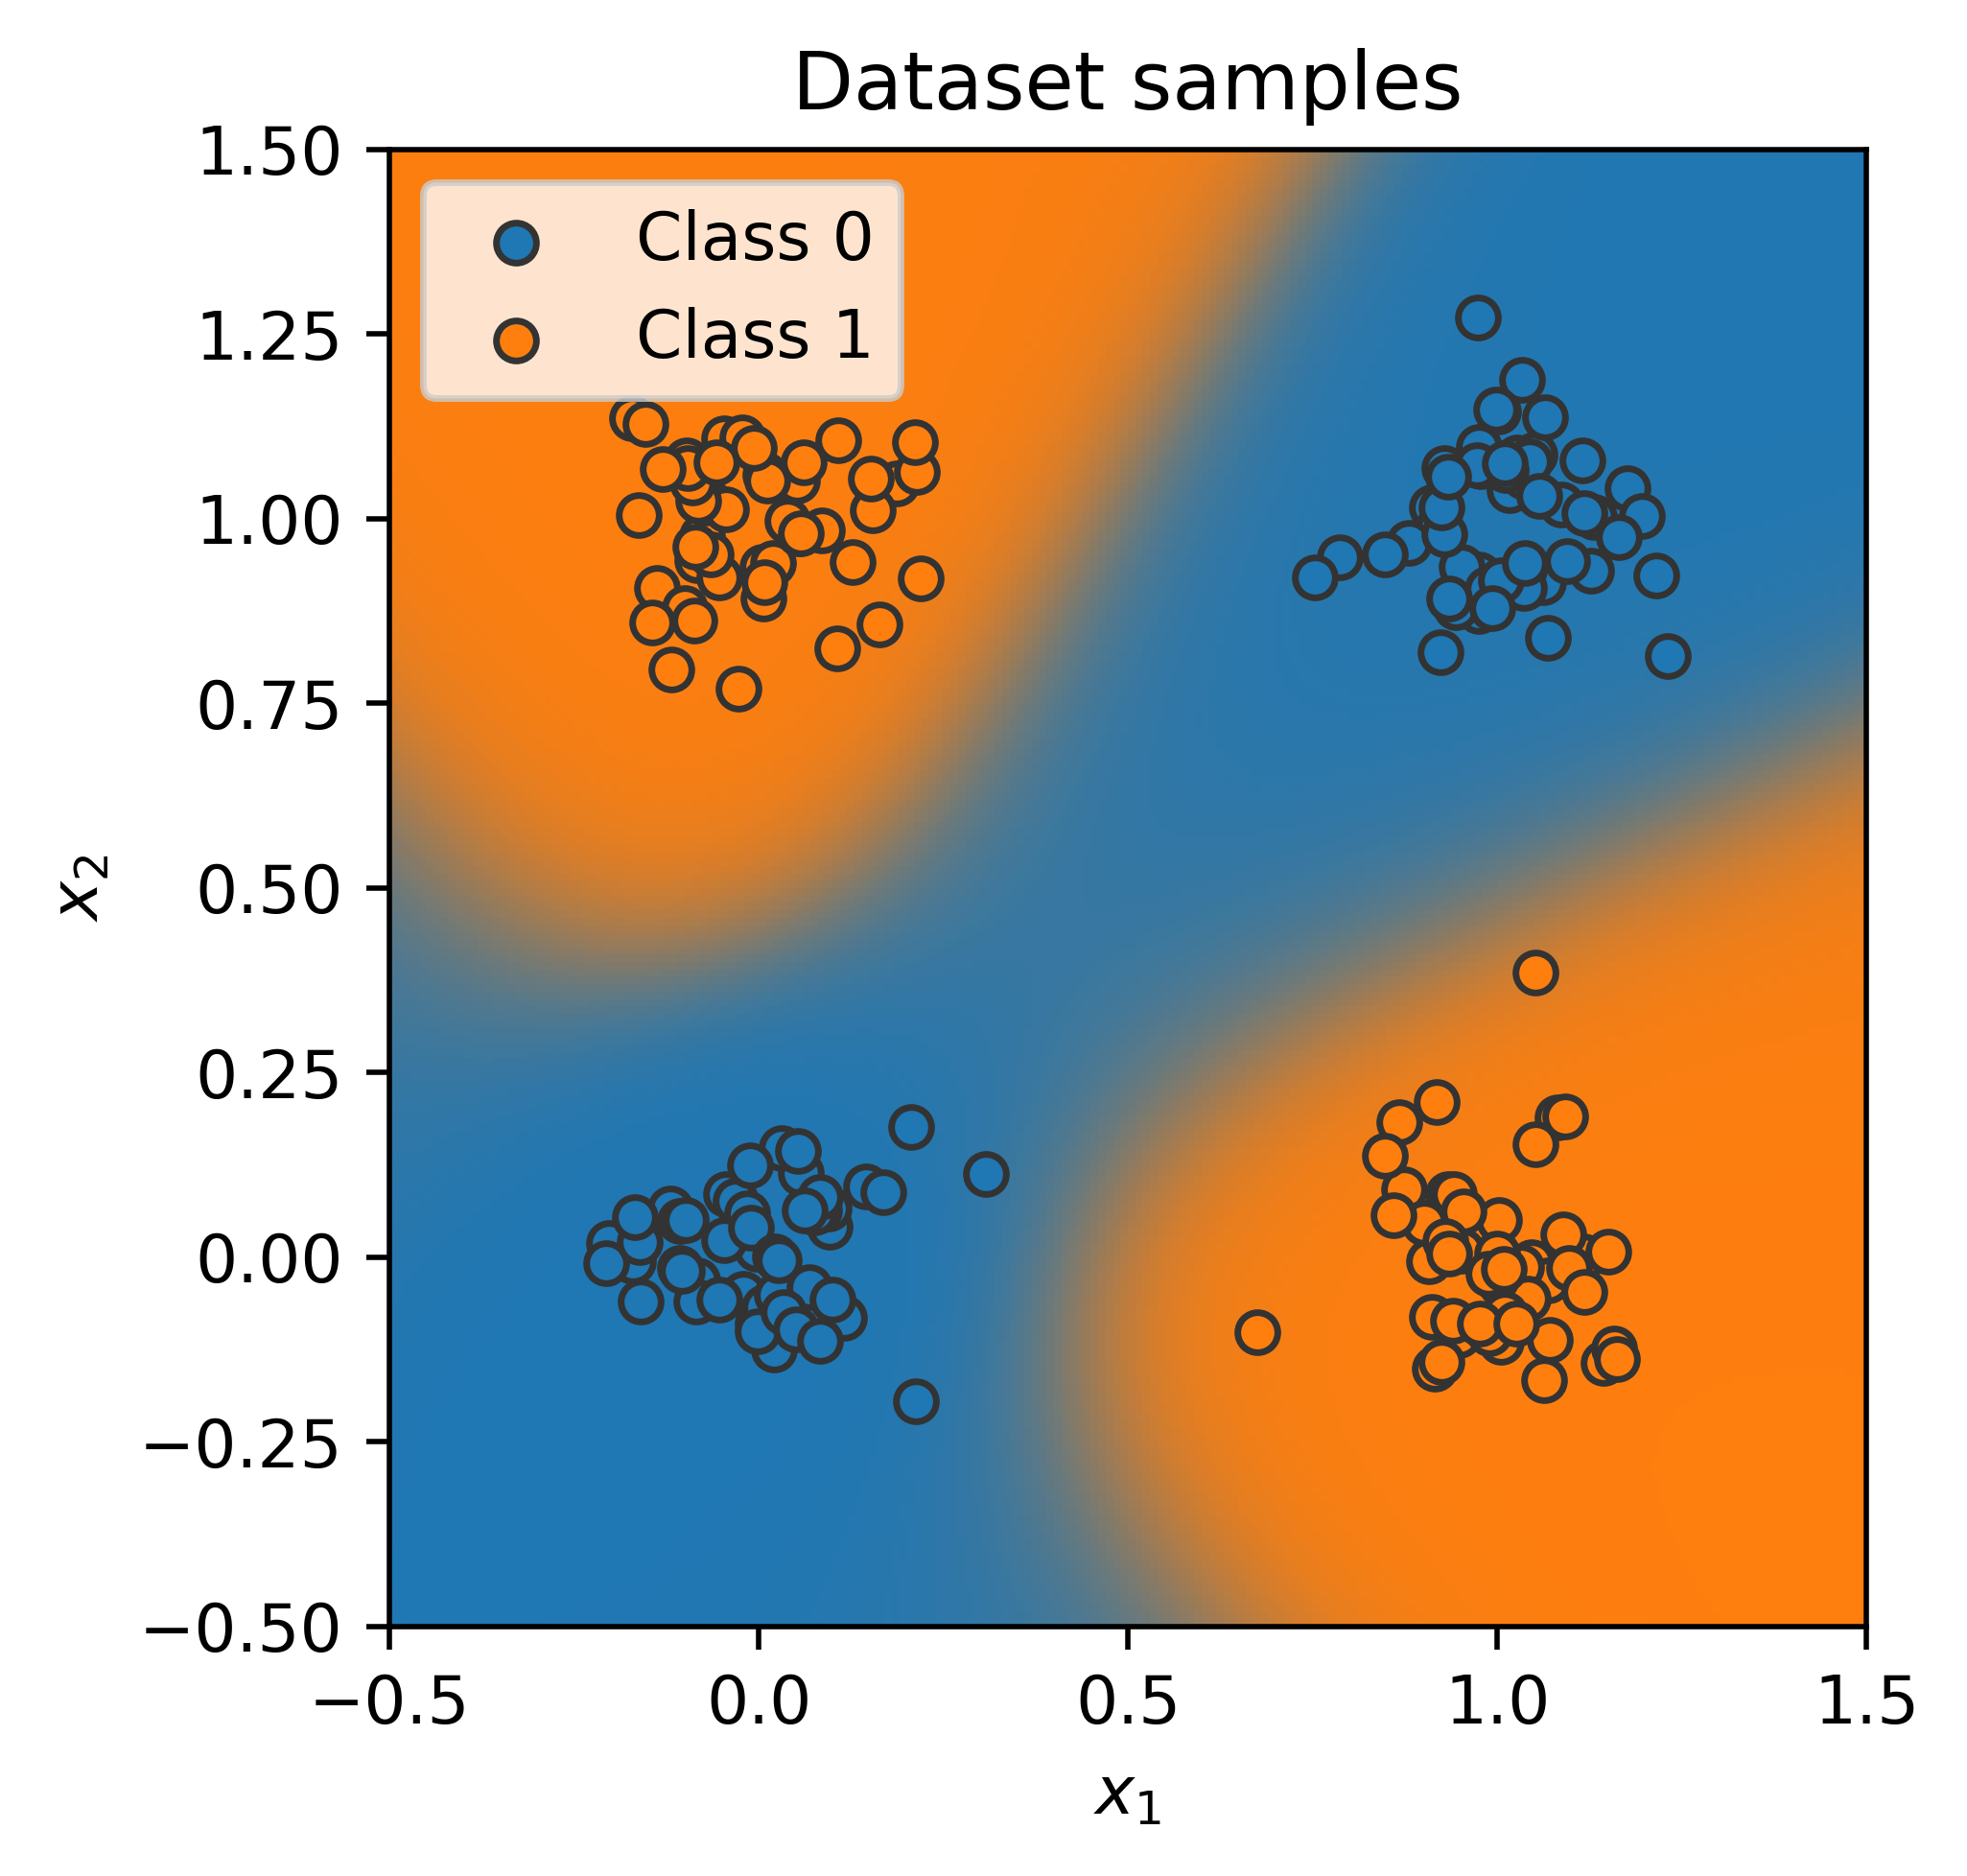

In [46]:
from matplotlib.colors import to_rgba
def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()